#### Contents:
* [Background](#Background)
* [Environment Setup](#Environment-Setup)
    * [Install the required python packages](#Install-the-required-python-packages)
    * [Import the required libraries](#Import-the-required-libraries)
* [Download and prepare the data](#Download-and-prepare-the-data)
* [Scenario 1: Related time series are available in the forecast horizon](#Scenario-1:-Related-time-series-are-available-in-the-forecast-horizon)
* [Scenario 2: Related time series is not available in the forecast horizon](#Scenario-2:-Related-time-series-is-not-available-in-the-forecast-horizon)
* [Scenario 3: Model all the time series as target series](#Model-all-the-time-series-as-target-series)

## 1. Background

Multivariate time series forecasting is a common problem and more recently deep learning models have been applied to time series forecasting. GluonTS is a deep learning toolkit for probabilistic modelling of time series. This notebook shows you different ways in which one can model a multivariate time series problem (time series with related variables) using different models that are implemented in GluonTS.

## 2. Environment Setup

## 2.1 Install the required python packages

In [34]:
!pip install --upgrade mxnet~=1.7
!pip install gluonts
!pip install mxnet-cu102==1.7.0

     |████████████████████████████████| 895.9 MB 8.2 kB/s  eta 0:00:01     |██████████████████▋             | 520.8 MB 71.6 MB/s eta 0:00:06     |█████████████████████▏          | 593.4 MB 66.9 MB/s eta 0:00:05


In [33]:
!pip uninstall -y mxnet

Found existing installation: mxnet 1.8.0.post0
Uninstalling mxnet-1.8.0.post0:
  Successfully uninstalled mxnet-1.8.0.post0


## 2.2 Import the required libraries

In [222]:
import pandas as pd
from gluonts.dataset.common import (
    CategoricalFeatureInfo,
    ListDataset,
    MetaData,
    TrainDatasets,
    load_datasets
)

from gluonts.dataset.field_names import FieldName
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.transformer import TransformerEstimator
from gluonts.model.lstnet import LSTNetEstimator
from gluonts.model.seq2seq import MQCNNEstimator
from gluonts.model.seq2seq import MQRNNEstimator
from gluonts.model.tft import TemporalFusionTransformerEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

import mxnet as mx

from itertools import islice
import matplotlib.pyplot as plt
%matplotlib inline

## 3. Download and prepare the data

We use the [PM 2.5 dataset](https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) from the UCI Machine Learning Repository.

The dataset contains PM 2.5 data from the US Embassy in Beijing and is supplemented with meteorological data. The following columns are part of the data - 
- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

Given the above information, here is how the different features in the dataset are treated - 
- pm2.5 is the target variable. 
- Meteorological variables like 'TEMP', 'DEWP' and 'PRES' can be treated as related time series with real values.
- 'cbwd' is a categorical variable and varies with time and can be treated as a dynamic categorical feature.

There are different ways in which one can model multivariate time series problems depending on the availability of related time series features in the forecast horizon. This notebook illustrates them by assuming the presence or absence of the meteorological variables in the forecast horizon.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

In [205]:
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

#combine month,day,hour into a timestamp
df['Timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

#set an ID to identify a time series
df['id'] = 0

#set the type of the categorical variable
df["cbwd"] = df["cbwd"].astype('category')
df["cbwd_cat"] = df["cbwd"].cat.codes

In [392]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir', 'Timestamp', 'id', 'cbwd_cat'],
      dtype='object')

## 4. Related time series are available in the forecast horizon

In this section, you will assume that the meteorological variables (TEMP, DEWP, PRES) are available to the model in the forecast horizon. In real life, this could be from a weather prediction model or forecast.

### 4.1 Prepare the training and testing dataset

In [313]:
forecast_length = 120
num_backtest_windows = 2

In [375]:
training_data_list = []
test_data_list = []

for i in reversed(range(1, num_backtest_windows+1)):
      
    training_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-fcast_length*i],
            "feat_static_cat": [0],
            "feat_dynamic_real": [df["TEMP"][:-fcast_length*i],
                                 df["DEWP"][:-fcast_length*i]],
            "feat_dynamic_cat": [df["cbwd_cat"][:-fcast_length*i]]
        }
        ]
    
    # create testing data.
    test_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-fcast_length*(i-1)] if i>1 else df["pm2.5"][:],
            "feat_static_cat": [0],
            "feat_dynamic_real": [df["TEMP"][:-fcast_length*(i-1)] if i>1 else df["TEMP"][:],
                                 df["DEWP"][:-fcast_length*(i-1)] if i>1 else df["DEWP"][:]],
            "feat_dynamic_cat": [df["cbwd_cat"][:-fcast_length*(i-1)] if i>1 else df["cbwd_cat"][:]]
        }
        ]

    training_data_list.append(ListDataset(training_data, freq='1h'))
    test_data_list.append(ListDataset(test_data, freq='1h'))

In [ ]:
#function that takes a gluonTS estimator, trains the model and predicts it for every pair of train and test dataset
def backtest(model,
             training_data_list,
             test_data_list,
             num_backtest_windows):
    
    forecasts = []
    obs = []
    
    #train a model for every backtest window
    for i in range(num_backtest_windows):
        predictor = model.train(training_data_list[i])
        forecast_it, ts_it = make_evaluation_predictions(test_data_list[i], 
                                                         predictor=predictor, 
                                                         num_samples=100)
        forecasts.extend(list(forecast_it))
        obs.extend(list(ts_it))
    return forecasts, obs

####  DeepAR

In [208]:
deepar = DeepAREstimator(freq="1h",
                         use_feat_static_cat=True,
                         use_feat_dynamic_real=True,
                         #use_feat_dynamic_cat=True,
                         cardinality=[1],
                         prediction_length=forecast_length,
                         trainer=Trainer(epochs=10, ctx = mx.context.gpu(0)),
                         num_cells=40)
forecast_deepar, obs_deepar = backtest(deepar,
                                       training_data_list,
                                       test_data_list,
                                       num_backtest_windows)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:23<00:00,  2.10it/s, epoch=10/10, avg_epoch_loss=4.07]


#### Transformer

In [377]:
transformer = TransformerEstimator(freq="1h",
                                   use_feat_dynamic_real=True,
                             prediction_length=forecast_length,
                             trainer=Trainer(epochs=10,
                                             learning_rate=0.01,
                                             ctx = mx.context.gpu(0))
                            )
forecast_transformer, obs_transformer = backtest(transformer,
                                                 training_data_list,
                                                 test_data_list,
                                                 num_backtest_windows)

100%|██████████| 50/50 [00:05<00:00,  9.01it/s, epoch=10/10, avg_epoch_loss=4.27]
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'enc_inputlayer0_dense0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'enc_inputlayer0_dense0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'enc_layernormalization0_layernorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-

#### Evaluation

In [210]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_deepar, item_metrics_deepar = evaluator(iter(obs_deepar), 
                                                        iter(forecast_deepar), 
                                                        num_series=len(forecast_deepar))

evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_transformer, item_metrics_transformer = evaluator(iter(obs_transformer),
                                                              iter(forecast_transformer),
                                                              num_series=len(forecast_transformer))


Running evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


In [212]:
pd.concat([pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"}),
           pd.DataFrame.from_dict(agg_metrics_transformer, orient='index').rename(columns={0: "Transformer"})],
         axis=1)

,DeepAR,Transformer
MSE,5291.321016,2346.828378
abs_error,25179.214844,483.099098
abs_target_sum,44105.000000,2282.000000
abs_target_mean,93.401082,114.100000
seasonal_error,69.167831,69.220338
MASE,0.770682,0.349120
MAPE,1.129428,0.362525
sMAPE,0.702841,0.287908
OWA,NaN,NaN
MSIS,4.167927,2.352895


In [380]:
def plot_forecasts(obs, forecasts, past_length, start, stop, step, title):
    for target, forecast in zip(obs, forecasts):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.title(title)
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

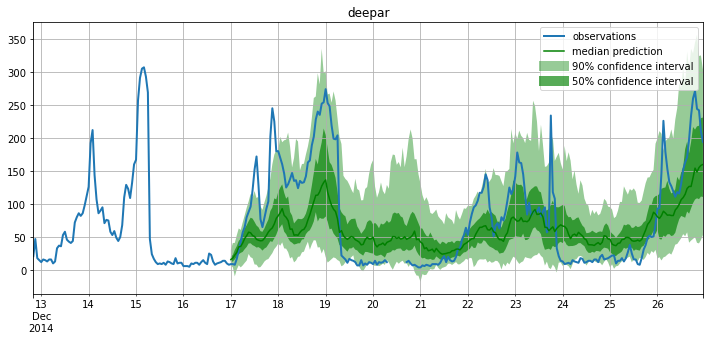

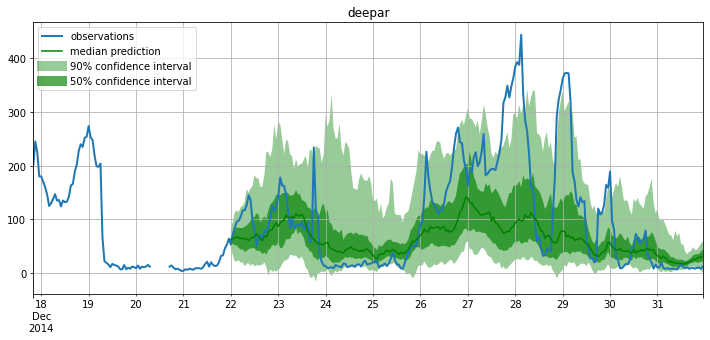

In [404]:
plot_forecasts(obs_deepar, forecast_deepar, 340, 0, 2, 1, 'deepar')

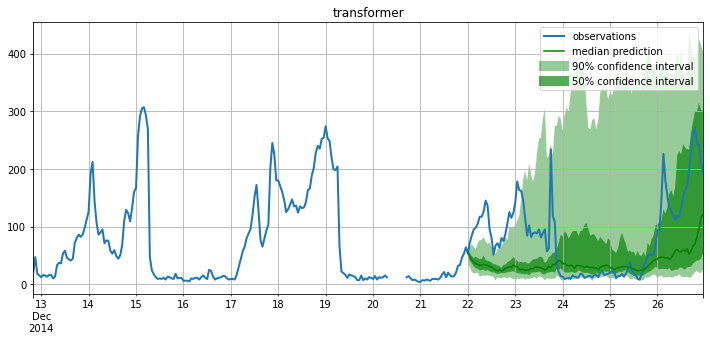

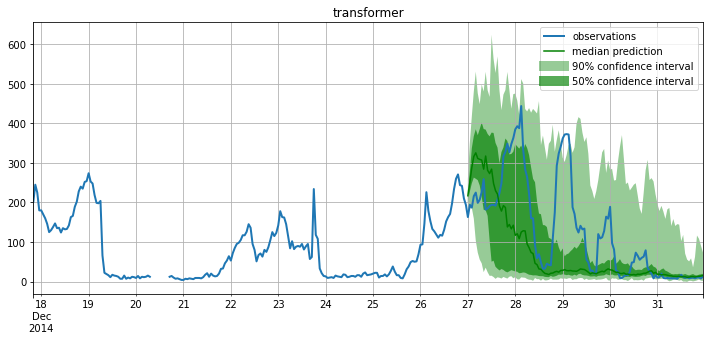

In [405]:
plot_forecasts(obs_transformer, forecast_transformer, 340, 0, 2, 1, 'transformer')

## 5. Related time series is not available in the forecast horizon

In this section, you will see how to train models when the related time series (meteorological features in this case) is not available in the forecast horizon. The meteorological variables are only present for the historical time period and can hence be used for training the model.

### 5.1 Prepare the training and testing dataset to use 'past_feat_dynamic_real'

In [382]:
training_data_list = []
test_data_list = []

for i in reversed(range(1, 3)):
      
    training_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-forecast_length*i],
            "past_feat_dynamic_real": [df["TEMP"][:-forecast_length*i],
                                 df["DEWP"][:-forecast_length*i]],
        }
        ]
    
    # create testing data.
    test_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-forecast_length*(i-1)] if i>1 else df["pm2.5"][:],
            "past_feat_dynamic_real": [df["TEMP"][:-forecast_length*(i-1)] if i>1 else df["TEMP"][:],
                                 df["DEWP"][:-forecast_length*(i-1)] if i>1 else df["DEWP"][:]],
        }
        ]

    training_data_list.append(ListDataset(training_data, freq='1h'))
    test_data_list.append(ListDataset(test_data, freq='1h'))

#### MQ-CNN

In [ ]:
#At times, one can encounter exploding gradients and as a result the loss can become a NaN. 
#set hybridize=False. May be related to https://github.com/awslabs/gluon-ts/issues/833
mqcnn = MQCNNEstimator(freq="1h",
                       use_past_feat_dynamic_real=True,
                       prediction_length=forecast_length,
                       trainer=Trainer(epochs=100,
                                       learning_rate=0.001,
                                       #clip_gradient=3,
                                       #batch_size=32,
                                       #num_batches_per_epoch=16,
                                       hybridize=False,
                                       ctx = mx.context.gpu(0)),
                       
                      )
forecast_mqcnn, obs_mqcnn = backtest(mqcnn,
                                   training_data_list,
                                   test_data_list,
                                   num_backtest_windows)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:12<00:00,  4.01it/s, epoch=100/100, avg_epoch_loss=0.198]
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv_00'_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv_00'_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning: Parameter 'conv_01'_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:893: UserWarning

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


 82%|████████▏ | 41/50 [00:10<00:02,  4.01it/s, epoch=89/100, avg_epoch_loss=0.158]

#### Temporal Fusion Transformer

In [397]:
training_data_list = []
test_data_list = []

for i in reversed(range(1, 3)):
      
    training_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-forecast_length*i],
            "past_feat_dynamic_real_1": df["TEMP"][:-forecast_length*i],
            "past_feat_dynamic_real_2": df["DEWP"][:-forecast_length*i],
            "past_feat_dynamic_real_3": df["Ir"][:-forecast_length*i]
        }
        ]
    
    # create testing data.
    test_data = [
        {
            "start": df.iloc[0]["Timestamp"],
            "target": df["pm2.5"][:-forecast_length*(i-1)] if i>1 else df["pm2.5"][:],
            "past_feat_dynamic_real_1": df["TEMP"][:-forecast_length*(i-1)] if i>1 else df["TEMP"][:],
            "past_feat_dynamic_real_2": df["DEWP"][:-forecast_length*(i-1)] if i>1 else df["DEWP"][:],
            "past_feat_dynamic_real_3": df["Ir"][:-forecast_length*(i-1)] if i>1 else df["Ir"][:]
        }
        ]

    training_data_list.append(ListDataset(training_data, freq='1h'))
    test_data_list.append(ListDataset(test_data, freq='1h'))

feat_past_dynamic_real = ["past_feat_dynamic_real_1", "past_feat_dynamic_real_2", "past_feat_dynamic_real_3"]

In [ ]:
#https://github.com/awslabs/gluon-ts/issues/1075
tft = TemporalFusionTransformerEstimator(freq = '1h',
                                         context_length=168,
                                         prediction_length = forecast_length,
                                         trainer=Trainer(epochs=100,
                                                         learning_rate=0.001,
                                                         ctx = mx.context.gpu(0)),
                                         hidden_dim=32,
                                         variable_dim=8,
                                         num_heads=4,
                                         num_outputs=3,
                                         num_instance_per_series=100,
                                         dropout_rate=0.1,
                                         dynamic_feature_dims={
                                             'past_feat_dynamic_real_1': 1,
                                             'past_feat_dynamic_real_2': 1,
                                             'past_feat_dynamic_real_3': 1
                                         }, # dimensions of dynamic real features
                                         past_dynamic_features=feat_past_dynamic_real,
                                        )
forecast_tft, obs_tft = backtest(tft,
                                 training_data_list,
                                 test_data_list,
                                 num_backtest_windows)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

In [399]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_mqcnn, item_metrics_mqcnn = evaluator(iter(obs_mqcnn), 
                                                    iter(forecast_mqcnn), 
                                                    num_series=len(forecast_mqcnn))

evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_tft, item_metrics_tft = evaluator(iter(obs_tft),
                                                  iter(forecast_tft),
                                                  num_series=len(forecast_tft))


Running evaluation: 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


In [400]:
pd.concat([pd.DataFrame.from_dict(agg_metrics_mqcnn, orient='index').rename(columns={0: "MQ-CNN"}),
           pd.DataFrame.from_dict(agg_metrics_mqrnn, orient='index').rename(columns={0: "TFT"})],
         axis=1)

,MQ-CNN,TFT
MSE,18916.025000,28345.460938
abs_error,25187.000000,3254.065674
abs_target_sum,25432.000000,2282.000000
abs_target_mean,105.966667,114.100000
seasonal_error,69.200225,69.220338
MASE,1.516515,2.350746
MAPE,2.602487,7.653351
sMAPE,1.112098,1.647021
OWA,NaN,NaN
MSIS,NaN,NaN


In [410]:
# 'QuantileForecast.plot' plots all the quantiles as line plots.
# This is some boiler plate code to plot an interval around the median 
# using the 10th and 90th quantile
def plot_from_quantile_forecast(obs, past_length, lower_bound, upper_bound, forecasts):
    plt.figure(figsize=(12,6))
    plt.plot(obs[0][-forecast_length-past_length:], label='observed')
    plt.plot(obs[0][-forecast_length:].index, 
             lower_bound,
            color='g',
            alpha=0.3,
            label='10th quantile')
    plt.plot(obs[0][-forecast_length:].index, 
             forecasts,
            color='g',
            label='median prediction')
    plt.plot(obs[0][-forecast_length:].index, 
             upper_bound,
            color='g',
            alpha=0.3,
            label='90th quantile')
    plt.fill_between(obs[0][-forecast_length:].index,
                     lower_bound, 
                     upper_bound,
                    color='g',
                    alpha=0.3)
    plt.legend()
    plt.grid(which="both")
    plt.show()

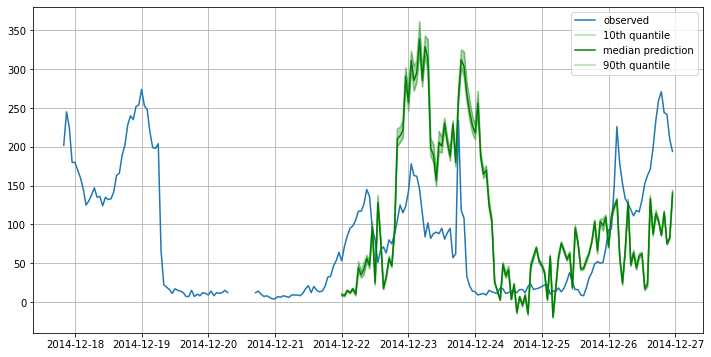

In [411]:
plot_from_quantile_forecast(obs_mqcnn, 
                            100, 
                            forecast_mqcnn[0].forecast_array[0], 
                            forecast_mqcnn[0].forecast_array[8],
                            forecast_mqcnn[0].forecast_array[4])

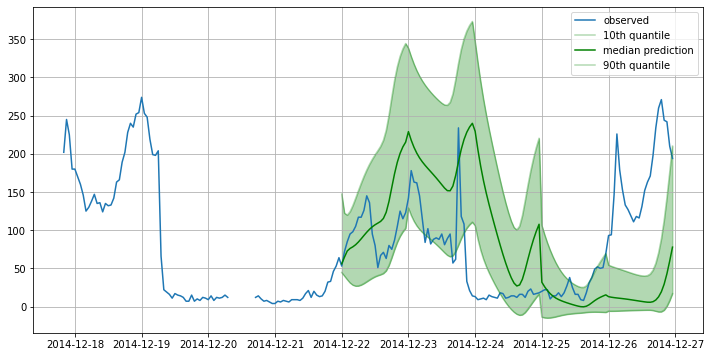

In [424]:
plot_from_quantile_forecast(obs_tft, 
                            100, 
                            forecast_tft[0].forecast_array[1], 
                            forecast_tft[0].forecast_array[2],
                            forecast_tft[0].forecast_array[0])

## 6. Model all the time series as target series

In this case, we forecast pm2.5 and the other meteorological features together as multivariate variables.

Models like LSTNet allow one to treat all the related time series in a multivariate fashion. One can train a model to forecast all the time series simultaneously.

For this, the data needs to be prepared in a different way and the below cell does that.

In [ ]:
train = df.transpose()
train2 = train.to_numpy()

target=train2[[5,6,7,8],:]

#prediction_length=24

start= [df.iloc[0]["Timestamp"] for _ in range(4)]


train_ds = ListDataset([{FieldName.TARGET: target, 
                         FieldName.START: start
                         } 
                        for (target, start) in zip(target[:, :-forecast_length], 
                                                            start)],
                      freq='1h')

test_ds = ListDataset([{FieldName.TARGET: target, 
                        FieldName.START: start
                       }
                       for (target, start) in zip(target[:, :],
                                                  start)],
                      freq='1h')


lstnet_estimator=LSTNetEstimator(freq='1h', 
                          prediction_length=forecast_length, 
                          context_length=240, 
                          num_series=4, 
                          skip_size=6, 
                          ar_window=24, 
                          channels=24, 
                          trainer = Trainer(epochs=100,
                                            ctx = mx.context.gpu(0)), 
                          dropout_rate = 0.2, 
                          output_activation = 'sigmoid', 
                          rnn_cell_type = 'lstm', 
                          rnn_num_cells = 100, 
                          rnn_num_layers = 3, 
                          skip_rnn_cell_type = 'lstm', 
                          skip_rnn_num_layers = 1, 
                          skip_rnn_num_cells = 10, 
                          scaling = True)


grouper_train = MultivariateGrouper(max_target_dim=4)

train_ds = grouper_train(train_ds)

lstnet_predictor = lstnet_estimator.train(train_ds)

grouper_test = MultivariateGrouper(max_target_dim=4)

test_ds = grouper_test(test_ds)

forecast_lstnet, obs_lstnet = make_evaluation_predictions(test_ds,
                                                          predictor=lstnet_predictor,
                                                         num_samples=100)

forecast_lstnet = list(forecast_lstnet)
obs_lstnet = list(obs_lstnet)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

In [444]:
evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics_lstnet, item_metrics_lstnet = evaluator(obs_lstnet, forecast_lstnet, num_series=len(test_ds))

index_series_map = {0: "pm 2.5",
                   1: "DEWP",
                   2: "TEMP",
                   3: "PRES"}
metrics_lstnet = []
for i in range(4):
    metrics = [k for k in agg_metrics_lstnet.keys() if k.startswith(str(i))]
    metrics_lstnet.append(pd.DataFrame.from_dict({m[2:]:agg_metrics_lstnet[m] for m in metrics},
                                                 orient='index').rename(columns={0: index_series_map[i]}))
pd.concat(metrics_lstnet, axis=1)  

Running evaluation: 1it [00:00, 91.16it/s]
Running evaluation: 1it [00:00, 140.29it/s]
Running evaluation: 1it [00:00, 137.18it/s]
Running evaluation: 1it [00:00, 142.44it/s]


,pm 2.5,DEWP,TEMP,PRES
MSE,18101.829167,210.312484,24.402934,77.696965
abs_error,11832.396484,1644.115234,506.247498,895.049072
abs_target_sum,15628.000000,1644.000000,506.000000,122707.000000
abs_target_mean,130.233333,13.700000,4.216667,1022.558333
seasonal_error,69.207897,4.238645,2.583341,3.760920
MASE,1.424741,3.232392,1.633052,1.983223
MAPE,1.746853,1.000069,1.001291,0.007321
sMAPE,0.957485,2.000000,1.984186,0.007288
OWA,NaN,NaN,NaN,NaN
MSIS,56.989628,129.295672,65.322059,79.328909


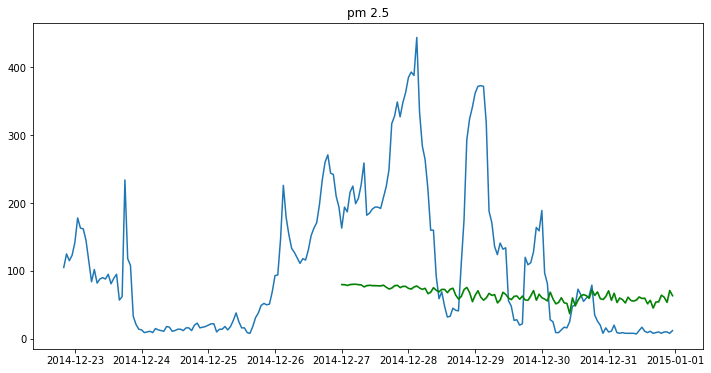

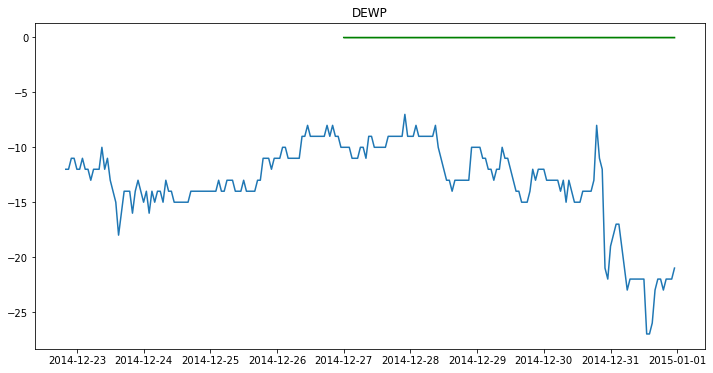

In [443]:

for x, y  in zip(obs_lstnet, forecast_lstnet):
    for i in range(2):
        plt.figure(figsize=(12,6))
        plt.plot(x[i][-forecast_length-100:])
        median = y.copy_dim(i).quantile(0.5)
        y_10 = y.copy_dim(i).quantile(0.1)
        y_90 = y.copy_dim(i).quantile(0.9)
        #print(y_10)
        #print(y_90)
        plt.plot(x[i][-forecast_length:].index,
                 median,
                color='g')
        plt.fill_between(x[i][-forecast_length:].index,
                         y_10,
                        y_90,
                        color='g',
                        alpha=0.3)
        plt.title(index_series_map[i])
        plt.show()